In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, LassoLars, BayesianRidge
from sklearn.linear_model import OrthogonalMatchingPursuit, Lars, ARDRegression

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit

import datetime as dt
import numpy as np
import itertools
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [10, 8]


from heat import rgb

In [2]:
print('Sklearn version: {}'.format(sklearn.__version__))
print('Opencv version: {}'.format(cv2.__version__))

Sklearn version: 0.24.1
Opencv version: 4.4.0


In [3]:
pd.set_option('display.float_format', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
# df_sam2_ori = pd.read_csv('./data/want_data.csv')
df_sam2_ori = pd.read_csv('data.csv')

In [5]:
predict_THV = pd.read_csv('./data/predict_THV.csv')
predict_TDP = pd.read_csv('./data/predict_TDP.csv')
predict_TDV = pd.read_csv('./data/predict_TDV.csv')
predict_PDP = pd.read_csv('./data/predict_PDP.csv')
predict_PDV = pd.read_csv('./data/predict_PDV.csv')

In [6]:
df_sam2 = df_sam2_ori.sort_values(['PID', 'AGE']).copy()

In [7]:
# data = [[-50 for i in range(9)] for i in range(8)]
# val_list = list(filter(lambda x : value in x, df_sam2.columns))
# want = df_sam2[['PID','AGE','Eye','Exam Date'] + val_list]
# predict_df = pd.read_csv('./data/predict_'+value+'.csv')

# sel_data = want[(want['PID']==pid)]
# predict_data = predict_df[(predict_df['PID']==pid)]
# predict_data = predict_data[['PID','AGE','Eye','Exam Date'] + list(filter(lambda x : 'predict' in x, predict_data.columns))]

# val_list.pop(25)
# val_list.pop(33)

# predict_data.columns = ['PID','AGE','Eye','Exam Date'] + val_list
# sel_data = pd.concat([sel_data, predict_data])
# sel_data[value+'_26'] = np.nan
# sel_data[value+'_35'] = np.nan

In [8]:
def show_person(value, pid):
    data = [[-50 for i in range(9)] for i in range(8)]
    val_list = list(filter(lambda x : value in x, df_sam2.columns))
    want = df_sam2[['PID','AGE','Eye','Exam Date'] + val_list]
    predict_df = pd.read_csv('./data/predict_'+value+'.csv')

    sel_data = want[(want['PID']==pid)]
    predict_data = predict_df[(predict_df['PID']==pid)]
    predict_data = predict_data[['PID','AGE','Eye','Exam Date'] + list(filter(lambda x : 'predict' in x, predict_data.columns))]

    val_list.pop(25)
    val_list.pop(33)

    predict_data.columns = ['PID','AGE','Eye','Exam Date'] + val_list
    sel_data = pd.concat([sel_data, predict_data])
    sel_data[value+'_26'] = np.nan
    sel_data[value+'_35'] = np.nan

    # fig, axs = plt.subplots(2, len(sel_data)-2, figsize=(30,40))

    # fig = plt.figure(1, figsize=(30, 40))
    fig, axs = plt.subplots(1, len(sel_data)-2, figsize=(30,40))
    for i in range(len(sel_data)-2):
        data[0][2:6] = list(sel_data.iloc[:,4:8].iloc[i])
        data[1][1:7] = list(sel_data.iloc[:,8:14].iloc[i])
        data[2][0:8] = list(sel_data.iloc[:,14:22].iloc[i])
        data[3] = list(sel_data.iloc[:,22:31].iloc[i])
        data[4] = list(sel_data.iloc[:,31:40].iloc[i])
        data[5][0:8] = list(sel_data.iloc[:,40:48].iloc[i])
        data[6][1:7] = list(sel_data.iloc[:,48:54].iloc[i])
        data[7][2:6] = list(sel_data.iloc[:,54:58].iloc[i])

        data = np.array(data)

    #     plt.figure(figsize = (9, 8))
        img = axs[i].imshow(data, cmap=plt.cm.Blues, 
                            vmax=sel_data.iloc[:,4:].max().max(), vmin=sel_data.iloc[:,4:].min().min()) #map표시
        fig.colorbar(img, fraction=0.046, pad=0.04)
        thresh = data.max()/2
        for k,j in itertools.product(range(data.shape[0]), range(data.shape[1])):
            if data[k, j] != -50:
                axs[i].text(j, k, data[k, j],
                        horizontalalignment='center',
                        color='white' if data[k, j] > thresh else 'black',
                        fontsize=6)
        axs[i].set_title(sel_data.iloc[i]['Exam Date'], fontsize=30, c='r')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        plt.sca(axs[i])

    fig, axs = plt.subplots(1, 2, figsize=(20,30))
    for i in range(2):
        data[0][2:6] = list(sel_data.iloc[:,4:8].iloc[len(sel_data)-2+i])
        data[1][1:7] = list(sel_data.iloc[:,8:14].iloc[len(sel_data)-2+i])
        data[2][0:8] = list(sel_data.iloc[:,14:22].iloc[len(sel_data)-2+i])
        data[3] = list(sel_data.iloc[:,22:31].iloc[len(sel_data)-2+i])
        data[4] = list(sel_data.iloc[:,31:40].iloc[len(sel_data)-2+i])
        data[5][0:8] = list(sel_data.iloc[:,40:48].iloc[len(sel_data)-2+i])
        data[6][1:7] = list(sel_data.iloc[:,48:54].iloc[len(sel_data)-2+i])
        data[7][2:6] = list(sel_data.iloc[:,54:58].iloc[len(sel_data)-2+i])

        data = np.array(data)

        #     plt.figure(figsize = (9, 8))
        img = axs[i].imshow(data, cmap=plt.cm.Blues, 
                            vmax=sel_data.iloc[:,4:].max().max(), vmin=sel_data.iloc[:,4:].min().min()) #map표시
        fig.colorbar(img, fraction=0.046, pad=0.04)
        thresh = data.max()/2
        for k,j in itertools.product(range(data.shape[0]), range(data.shape[1])):
            if data[k, j] != -50:
                axs[i].text(j, k, data[k, j],
                        horizontalalignment='center',
                        color='white' if data[k, j] > thresh else 'black',
                        fontsize=15)
        if i == 0 :
            axs[i].set_title(sel_data.iloc[len(sel_data)-2+i]['Exam Date'], fontsize=30, c='r')
        else : 
            axs[i].set_title('Predict', fontsize=30, c='r')

        axs[i].set_xticks([])
        axs[i].set_yticks([])
        plt.sca(axs[i])

    plt.show()

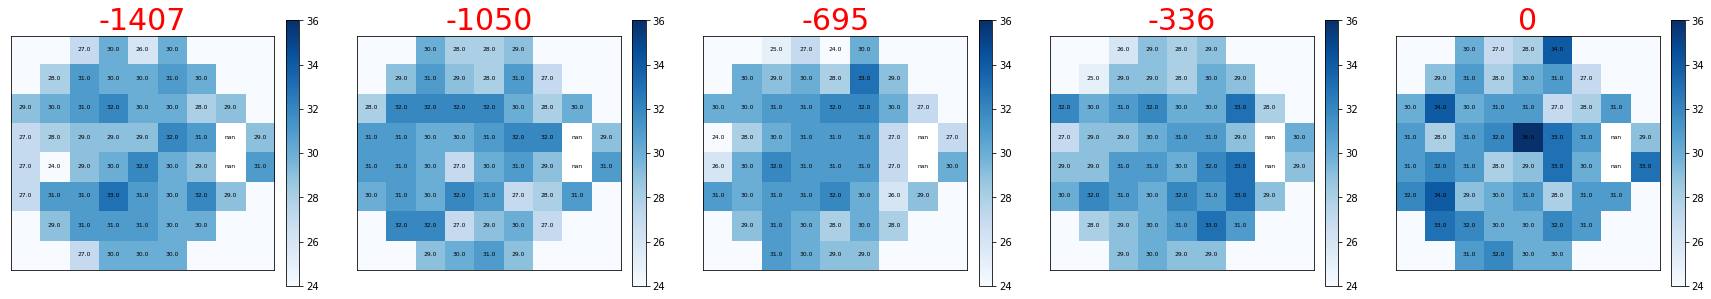

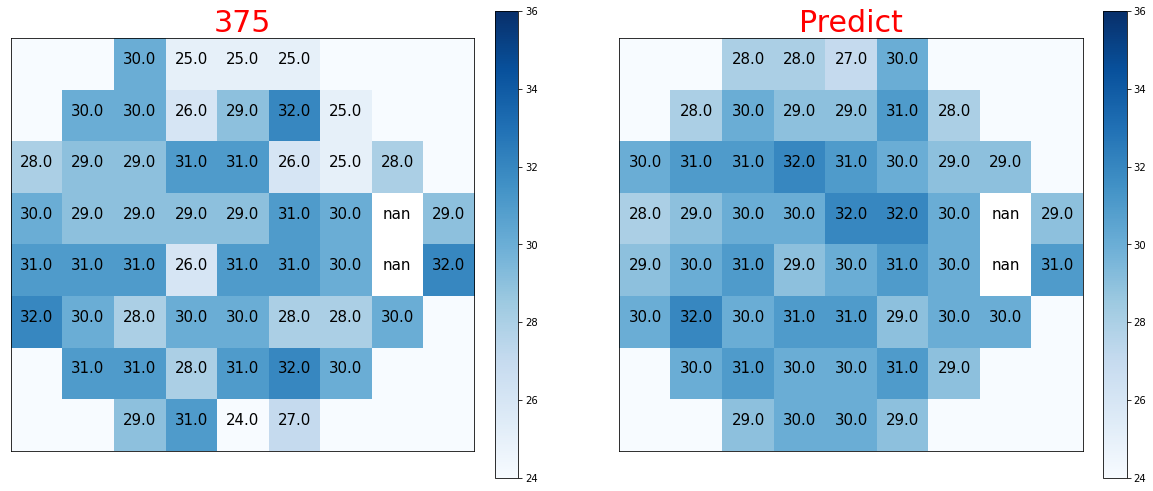

In [10]:
show_person('THV', 1)